# Import necessary libraries

In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 17.0 MB/s eta 0:00:00


In [51]:
import os
import shap
import time
import pickle
import random
import optuna
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from pprint import pprint
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate, GlobalMaxPooling1D

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Data Loading

In [5]:
df = pd.read_csv("/content/IMBD.csv")

In [6]:
OUTPUT_DIR = "output_lstm_hpo_shap"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [7]:
df.head(20)

,title,year,certificate,duration,genre,rating,description,stars,votes
0,Cobra Kai,(2018– ),TV-14,30 min,"Action, Comedy, Drama",8.5,Decades after their 1984 All Valley Karate Tou...,"['Ralph Macchio, ', 'William Zabka, ', 'Courtn...","177,031"
1,The Crown,(2016– ),TV-MA,58 min,"Biography, Drama, History",8.7,Follows the political rivalries and romance of...,"['Claire Foy, ', 'Olivia Colman, ', 'Imelda St...","199,885"
2,Better Call Saul,(2015–2022),TV-MA,46 min,"Crime, Drama",8.9,The trials and tribulations of criminal lawyer...,"['Bob Odenkirk, ', 'Rhea Seehorn, ', 'Jonathan...","501,384"
3,Devil in Ohio,(2022),TV-MA,356 min,"Drama, Horror, Mystery",5.9,When a psychiatrist shelters a mysterious cult...,"['Emily Deschanel, ', 'Sam Jaeger, ', 'Gerardo...","9,773"
4,Cyberpunk: Edgerunners,(2022– ),TV-MA,24 min,"Animation, Action, Adventure",8.6,A Street Kid trying to survive in a technology...,"['Zach Aguilar, ', 'Kenichiro Ohashi, ', 'Emi ...","15,413"
5,The Sandman,(2022– ),TV-MA,45 min,"Drama, Fantasy, Horror",7.8,Upon escaping after decades of imprisonment by...,"['Tom Sturridge, ', 'Boyd Holbrook, ', 'Patton...","116,358"
6,Rick and Morty,(2013– ),TV-MA,23 min,"Animation, Adventure, Comedy",9.2,An animated series that follows the exploits o...,"['Justin Roiland, ', 'Chris Parnell, ', 'Spenc...","502,160"
7,Breaking Bad,(2008–2013),TV-MA,49 min,"Crime, Drama, Thriller",9.5,A high school chemistry teacher diagnosed with...,"['Bryan Cranston, ', 'Aaron Paul, ', 'Anna Gun...","1,831,340"
8,The Imperfects,(2022– ),TV-MA,45 min,"Action, Adventure, Drama",6.3,After an experimental gene therapy turns them ...,"['Morgan Taylor Campbell, ', 'Italia Ricci, ',...","3,123"
9,Blonde,(2022),NC-17,166 min,"Biography, Drama, Mystery",6.2,A fictionalized chronicle of the inner life of...,"['Andrew Dominik', '| ', ' Stars:', 'Ana de...",935


In [8]:
print("Columns:", df.columns.tolist())

Columns: ['title', 'year', 'certificate', 'duration', 'genre', 'rating', 'description', 'stars', 'votes']


In [9]:
df.dtypes

,0
title,object
year,object
certificate,object
duration,object
genre,object
rating,float64
description,object
stars,object
votes,object


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9957 entries, 0 to 9956
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        9957 non-null   object 
 1   year         9430 non-null   object 
 2   certificate  6504 non-null   object 
 3   duration     7921 non-null   object 
 4   genre        9884 non-null   object 
 5   rating       8784 non-null   float64
 6   description  9957 non-null   object 
 7   stars        9957 non-null   object 
 8   votes        8784 non-null   object 
dtypes: float64(1), object(8)
memory usage: 700.2+ KB


In [11]:
df.shape

(9957, 9)

In [12]:
df = df.dropna(subset=['description','rating']).copy()

In [13]:
print(f"Number of null values in 'description': {df['description'].isnull().sum()}, Number of null values in 'rating': {df['rating'].isnull().sum()}")

Number of null values in 'description': 0, Number of null values in 'rating': 0


In [14]:
df.shape

(8784, 9)

In [15]:
print("\nRating stats:")
print(df['rating'].describe())


Rating stats:
count    8784.000000
mean        6.764515
std         1.214840
min         1.700000
25%         6.100000
50%         6.900000
75%         7.600000
max         9.900000
Name: rating, dtype: float64


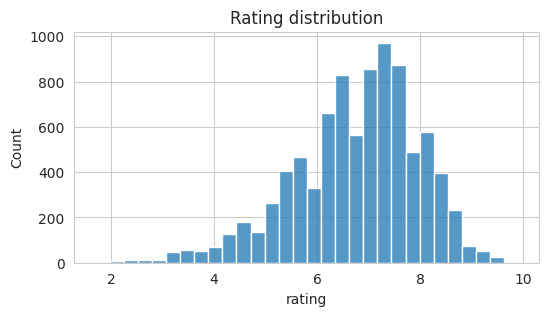

In [16]:
# Histogram of ratings
plt.figure(figsize=(6,3))
sns.histplot(df['rating'], bins=30, kde=False)
plt.title("Rating distribution")
plt.savefig(os.path.join(OUTPUT_DIR, "rating_hist.png"))

In [17]:
df['label'] = (df['rating'] >= 7).astype(int)
print("\nLabel distribution (Good=1):")
print(df['label'].value_counts(normalize=True))


Label distribution (Good=1):
label
0    0.511612
1    0.488388
Name: proportion, dtype: float64


In [18]:
# PREPROCESSING
for col in ['votes', 'duration', 'year']:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(',', '', regex=False)  # remove commas like "177,031"
            .str.extract(r'(\d+\.?\d*)')[0]     # extract numeric part
            .astype(float)
        )
    else:
        df[col] = 0.0

In [19]:
# Clean genre: if multiple genres separated by '|' or ',' convert to first genre for simplicity
def extract_primary_genre(g):
    if pd.isna(g):
        return "unknown"
    # common separators
    for sep in ['|', ',', ';', '/']:
        if sep in str(g):
            return str(g).split(sep)[0].strip().lower()
    return str(g).strip().lower()

df['genre_primary'] = df['genre'].apply(extract_primary_genre)

# View first few rows to check extraction
print(df[['genre', 'genre_primary']].head())


                          genre genre_primary
0         Action, Comedy, Drama        action
1     Biography, Drama, History     biography
2                  Crime, Drama         crime
3        Drama, Horror, Mystery         drama
4  Animation, Action, Adventure     animation


In [20]:
# Numeric metadata: votes, duration, year => fillna and scale
meta_cols = ['votes','duration','year']
df[meta_cols] = df[meta_cols].fillna(0).astype(float)
scaler = StandardScaler()
meta_scaled = scaler.fit_transform(df[meta_cols])

# One-hot encode primary genre (top-k)
TOP_GENRES = 20
top_genres = df['genre_primary'].value_counts().nlargest(TOP_GENRES).index.tolist()
def genre_vector(g):
    vec = [0]*len(top_genres)
    if g in top_genres:
        vec[top_genres.index(g)] = 1
    return vec

genre_matrix = np.array([genre_vector(g) for g in df['genre_primary']])

print(genre_matrix)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [21]:
# Combined metadata matrix
X_meta = np.hstack([meta_scaled, genre_matrix])

In [22]:
# Text tokenizer
texts = df['description'].astype(str).tolist()
print(texts)
VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

['Decades after their 1984 All Valley Karate Tournament bout, a middle-aged Daniel LaRusso and Johnny Lawrence find themselves martial-arts rivals again.', "Follows the political rivalries and romance of Queen Elizabeth II's reign and the events that shaped the second half of the twentieth century.", 'The trials and tribulations of criminal lawyer Jimmy McGill before his fateful run-in with Walter White and Jesse Pinkman.', "When a psychiatrist shelters a mysterious cult escapee, her world is turned upside down as the girl's arrival threatens to tear her own family apart.", 'A Street Kid trying to survive in a technology and body modification-obsessed city of the future. Having everything to lose, he chooses to stay alive by becoming an Edgerunner, a Mercenary outlaw also known as a Cyberpunk.', 'Upon escaping after decades of imprisonment by a mortal wizard, Dream, the personification of dreams, sets about to reclaim his lost equipment.', 'An animated series that follows the exploits 

In [23]:
# Choose maxlen based on distribution
lengths = [len(s) for s in sequences]
print("Text length percentiles:", np.percentile(lengths, [25,50,75,90,95]))
MAXLEN = 40  # reasonable default; adjust after observing distribution
X_text = pad_sequences(sequences, maxlen=MAXLEN, padding='post', truncating='post')

y = df['label'].values

Text length percentiles: [21. 26. 33. 38. 40.]


In [24]:
# Train/validation/test split (stratify by label)
X_text_train, X_text_temp, X_meta_train, X_meta_temp, y_train, y_temp = train_test_split(
    X_text, X_meta, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y
)
X_text_val, X_text_test, X_meta_val, X_meta_test, y_val, y_test = train_test_split(
    X_text_temp, X_meta_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=y_temp
)

print("Train/Val/Test shapes:", X_text_train.shape, X_text_val.shape, X_text_test.shape)

Train/Val/Test shapes: (6148, 40) (1318, 40) (1318, 40)


In [25]:
# Save tokenizer & scaler
with open(os.path.join(OUTPUT_DIR, "tokenizer.pkl"), "wb") as f:
    pickle.dump(tokenizer, f)
with open(os.path.join(OUTPUT_DIR, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

In [26]:
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [62]:
#  Baseline model (TF-IDF + Logistic Regression)
print("\nTraining baseline TF-IDF + Logistic Regression...")

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df['description'].astype(str))

# Split for baseline (clean version)
X_b_train_idx, X_b_temp_idx, y_b_train, y_b_temp = train_test_split(np.arange(len(df)), y, test_size=0.3, random_state=RANDOM_SEED, stratify=y
)
X_b_val_idx, X_b_test_idx, y_b_val, y_b_test = train_test_split(X_b_temp_idx, y_b_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=y_b_temp
)

X_tfidf_train = X_tfidf[X_b_train_idx]
X_tfidf_val = X_tfidf[X_b_val_idx]
X_tfidf_test = X_tfidf[X_b_test_idx]

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_tfidf_train, y_b_train)

y_lr_pred_proba = lr.predict_proba(X_tfidf_test)[:, 1]
y_lr_pred = (y_lr_pred_proba >= 0.5).astype(int)
y_val_pred = lr.predict(X_tfidf_val)
val_acc = accuracy_score(y_b_val, y_val_pred)

print("Baseline metrics:")
print("Accuracy:", accuracy_score(y_b_test, y_lr_pred))
print("F1:", f1_score(y_b_test, y_lr_pred))
print("ROC AUC:", roc_auc_score(y_b_test, y_lr_pred_proba))
print(f"Val_acc: {val_acc:.4f}")


Training baseline TF-IDF + Logistic Regression...
Baseline metrics:
Accuracy: 0.6168437025796661
F1: 0.6045418950665623
ROC AUC: 0.6627337134957664
Val_acc: 0.6206


In [28]:
# Save Training baseline TF-IDF + Logistic Regression...
with open(os.path.join(OUTPUT_DIR, "baseline_lr.pkl"), "wb") as f:
    pickle.dump((tfidf, lr), f)

In [63]:
# build text+meta LSTM model factory
def build_model(vocab_size=VOCAB_SIZE, maxlen=MAXLEN, emb_dim=128, lstm_units=128,
                meta_dim=X_meta.shape[1], dense_units=64, dropout_rate=0.6, optimizer_name='adam', lr=1e-3):
    text_in = Input(shape=(maxlen,), name='text_in')
    x = Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=maxlen)(text_in)
    x = Bidirectional(LSTM(lstm_units, return_sequences=False))(x)
    x = Dropout(dropout_rate)(x)

    meta_in = Input(shape=(meta_dim,), name='meta_in')
    m = Dense(int(meta_dim/2), activation='relu')(meta_in)

    concat = Concatenate()([x, m])
    h = Dense(dense_units, activation='relu')(concat)
    h = Dropout(dropout_rate)(h)
    out = Dense(1, activation='sigmoid')(h)

    model = Model([text_in, meta_in], out)

    if optimizer_name == 'adam':
        opt = Adam(learning_rate=lr)
    elif optimizer_name == 'rmsprop':
        opt = RMSprop(learning_rate=lr)
    elif optimizer_name == 'sgd':
      opt = SGD(learning_rate=lr, momentum=0.9)
    else:
        opt = Adam(learning_rate=lr)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

In [64]:
# Quick sanity build
m = build_model()
m.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_in             │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 40, 128)   │  1,280,000 │ text_in[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    263,168 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_in             │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 11)        │        264 │ meta_in[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 267)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     17,152 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,560,649 (5.95 MB)

 Trainable params: 1,560,649 (5.95 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Train baseline LSTM

print("\nTraining baseline LSTM ")
baseline_model = build_model(emb_dim=128, lstm_units=128, dense_units=64, dropout_rate=0.6, optimizer_name='adam', lr=1e-3)

es = EarlyStopping(monitor='val_auc', mode='max', patience=2, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_auc', mode='max', patience=1, factor=0.5, min_lr=1e-6, verbose=1)

hist = baseline_model.fit([X_text_train, X_meta_train], y_train,
                          validation_data=([X_text_val, X_meta_val], y_val),
                          epochs=30, batch_size=64, callbacks=[es, rlr], verbose=1)

val_acc = max(hist.history['val_accuracy'])

# Evaluate baseline LSTM on test
y_pred_proba = baseline_model.predict([X_text_test, X_meta_test])[:,0]
y_pred = (y_pred_proba >= 0.5).astype(int)
print("Baseline LSTM Test metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("Validation Accuracy:", val_acc)


Training baseline LSTM 
Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5472 - auc: 0.5648 - loss: 0.6870 - val_accuracy: 0.6457 - val_auc: 0.6872 - val_loss: 0.6568 - learning_rate: 0.0010
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6632 - auc: 0.7238 - loss: 0.6248 - val_accuracy: 0.6259 - val_auc: 0.6957 - val_loss: 0.6611 - learning_rate: 0.0010
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8043 - auc: 0.8817 - loss: 0.4375
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8044 - auc: 0.8818 - loss: 0.4372 - val_accuracy: 0.6252 - val_auc: 0.6831 - val_loss: 0.8864 - learning_rate: 0.0010
Epoch 4/30
95/97 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9073 - auc: 0.9637 - loss: 0.2492
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9072 - auc: 0.9636 - loss: 0.2496

In [32]:
# Save baseline LSTM
baseline_model.save(os.path.join(OUTPUT_DIR, "baseline_lstm.h5"))

In [37]:
def random_search(n_trials=20, epochs=6):
    print(f"\nStarting Random Search: {n_trials} trials, {epochs} epochs each")
    trials = []

    for t in trange(n_trials):
        config = {
            'emb_dim': random.choice([64, 128, 256]),
            'lstm_units': random.choice([64, 128, 256]),
            'dense_units': random.choice([32, 64, 128]),
            'dropout_rate': random.uniform(0.1, 0.5),
            'lr': 10**random.uniform(-4, -2),
            'batch_size': random.choice([32, 64, 128]),
            'optimizer': random.choice(['adam','rmsprop','sgd'])
        }

        model = build_model(
            emb_dim=config['emb_dim'],
            lstm_units=config['lstm_units'],
            dense_units=config['dense_units'],
            dropout_rate=config['dropout_rate'],
            optimizer_name=config['optimizer'],
            lr=config['lr']
        )

        es = EarlyStopping(
            monitor='val_auc',
            mode='max',
            patience=3,
            restore_best_weights=True
        )

        history = model.fit(
            [X_text_train, X_meta_train], y_train,
            validation_data=([X_text_val, X_meta_val], y_val),
            epochs=epochs,
            batch_size=config['batch_size'],
            callbacks=[es],
            verbose=0
        )

        best_val_auc = max(history.history.get('val_auc', [0]))
        config['val_auc'] = best_val_auc

        # test metrics
        y_pred_proba = model.predict([X_text_test, X_meta_test])[:, 0]
        y_pred = (y_pred_proba >= 0.5).astype(int)

        config['test_accuracy'] = accuracy_score(y_test, y_pred)
        config['test_f1'] = f1_score(y_test, y_pred)
        config['test_auc'] = roc_auc_score(y_test, y_pred_proba)

        trials.append(config)

    trials_sorted = sorted(trials, key=lambda x: x.get('val_auc', 0), reverse=True)
    return trials_sorted

random_trials = random_search(n_trials=20, epochs=6)
print("Top 5 random search configs:")
pprint(random_trials[:5])


Starting Random Search: 20 trials, 6 epochs each


  0%|          | 0/20 [00:00<?, ?it/s]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


  5%|▌         | 1/20 [00:15<04:48, 15.16s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


 10%|█         | 2/20 [00:25<03:47, 12.61s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 15%|█▌        | 3/20 [00:35<03:10, 11.20s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 20%|██        | 4/20 [00:48<03:08, 11.78s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


 25%|██▌       | 5/20 [01:03<03:15, 13.01s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 30%|███       | 6/20 [01:10<02:36, 11.14s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


 35%|███▌      | 7/20 [01:22<02:26, 11.27s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 40%|████      | 8/20 [01:31<02:05, 10.43s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 45%|████▌     | 9/20 [01:43<02:01, 11.08s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 50%|█████     | 10/20 [01:54<01:51, 11.13s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 55%|█████▌    | 11/20 [02:14<02:04, 13.86s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


 60%|██████    | 12/20 [02:26<01:45, 13.22s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


 65%|██████▌   | 13/20 [02:35<01:23, 11.90s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 70%|███████   | 14/20 [02:42<01:02, 10.34s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


 75%|███████▌  | 15/20 [02:58<01:00, 12.18s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


 80%|████████  | 16/20 [03:07<00:44, 11.21s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 85%|████████▌ | 17/20 [03:16<00:31, 10.55s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 90%|█████████ | 18/20 [03:25<00:19,  9.90s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


 95%|█████████▌| 19/20 [03:32<00:09,  9.11s/it]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


100%|██████████| 20/20 [03:51<00:00, 11.58s/it]

Top 5 random search configs:
[{'batch_size': 32,
  'dense_units': 32,
  'dropout_rate': 0.14613670074057106,
  'emb_dim': 256,
  'lr': 0.008725718980629989,
  'lstm_units': 128,
  'optimizer': 'sgd',
  'test_accuracy': 0.7003034901365706,
  'test_auc': np.float64(0.7715431138759288),
  'test_f1': 0.7208480565371025,
  'val_auc': 0.7648470997810364},
 {'batch_size': 32,
  'dense_units': 64,
  'dropout_rate': 0.22207634693544023,
  'emb_dim': 64,
  'lr': 0.0038966464058009655,
  'lstm_units': 128,
  'optimizer': 'adam',
  'test_accuracy': 0.6919575113808801,
  'test_auc': np.float64(0.7638361845515811),
  'test_f1': 0.723433242506812,
  'val_auc': 0.7544360756874084},
 {'batch_size': 64,
  'dense_units': 128,
  'dropout_rate': 0.17777409469588373,
  'emb_dim': 128,
  'lr': 0.002470065677212394,
  'lstm_units': 256,
  'optimizer': 'rmsprop',
  'test_accuracy': 0.6669195751138088,
  'test_auc': np.float64(0.7575946086054951),
  'test_f1': 0.7143786597267404,
  'val_auc': 0.7485658526420593

In [38]:
# Save
with open(os.path.join(OUTPUT_DIR, "random_search_results.pkl"), "wb") as f:
    pickle.dump(random_trials, f)

In [39]:
 pip install optuna-integration[tfkeras]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.0 MB/s eta 0:00:00


In [77]:
from optuna.integration import TFKerasPruningCallback
def optuna_objective(trial):
    # Hyperparameter search space
    emb_dim = trial.suggest_categorical('emb_dim', [64, 128, 256])
    lstm_units = trial.suggest_categorical('lstm_units', [64, 128, 256])
    dense_units = trial.suggest_categorical('dense_units', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    # Build model
    model = build_model(
        emb_dim=emb_dim,
        lstm_units=lstm_units,
        dense_units=dense_units,
        dropout_rate=dropout_rate,
        optimizer_name=optimizer_name,
        lr=lr
    )

    # Compile model
    model.compile(
        loss='binary_crossentropy',
        optimizer=model.optimizer,
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    # Callbacks
    pruning_callback = TFKerasPruningCallback(trial, "val_auc")
    es = EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)

    # Train
    history = model.fit(
        [X_text_train, X_meta_train], y_train,
        validation_data=([X_text_val, X_meta_val], y_val),
        epochs=30,  # Increase epochs for better convergence
        batch_size=batch_size,
        callbacks=[es, pruning_callback],
        verbose=0
    )

    # Best validation AUC
    val_auc = max(history.history.get('val_auc', [0.0]))

    # Clear session to avoid memory leak
    tf.keras.backend.clear_session()

    return val_auc

# --- Run the Optuna study ---
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3)
)

N_TRIALS = 50
study.optimize(optuna_objective, n_trials=N_TRIALS, show_progress_bar=True)

# --- Best trial ---
print("Best trial parameters:")
print(study.best_trial.params)

[I 2025-12-06 09:35:19,031] A new study created in memory with name: no-name-c260a6a0-793f-42d2-ad64-7514502ecf2e


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-06 09:35:51,327] Trial 0 finished with value: 0.7145518660545349 and parameters: {'emb_dim': 128, 'lstm_units': 64, 'dense_units': 64, 'dropout_rate': 0.35403628889802274, 'lr': 0.00010485387725194633, 'batch_size': 32, 'optimizer': 'adam'}. Best is trial 0 with value: 0.7145518660545349.
[I 2025-12-06 09:36:06,632] Trial 1 finished with value: 0.7081114053726196 and parameters: {'emb_dim': 256, 'lstm_units': 256, 'dense_units': 128, 'dropout_rate': 0.22803499210851796, 'lr': 0.0006097839109531517, 'batch_size': 64, 'optimizer': 'adam'}. Best is trial 0 with value: 0.7145518660545349.
[I 2025-12-06 09:36:29,083] Trial 2 finished with value: 0.7203782796859741 and parameters: {'emb_dim': 64, 'lstm_units': 128, 'dense_units': 128, 'dropout_rate': 0.22007624686980065, 'lr': 0.00013244581340099356, 'batch_size': 32, 'optimizer': 'adam'}. Best is trial 2 with value: 0.7203782796859741.
[I 2025-12-06 09:36:45,721] Trial 3 finished with value: 0.7352150082588196 and parameters: {'e

In [78]:
best_params = study.best_trial.params
best_params

{'emb_dim': 64,
 'lstm_units': 128,
 'dense_units': 128,
 'dropout_rate': 0.16778345601508363,
 'lr': 0.0009473202586559989,
 'batch_size': 64,
 'optimizer': 'rmsprop'}

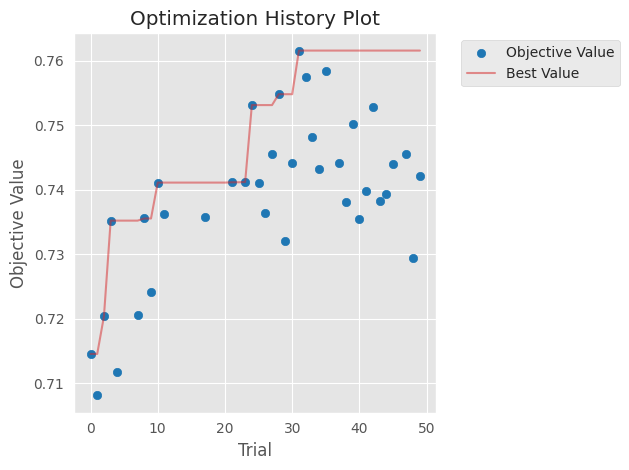

In [79]:
# Plot optimization history (if running in notebook)
try:
    fig = optuna.visualization.matplotlib.plot_optimization_history(study)
    fig.figure.savefig(os.path.join(OUTPUT_DIR, "optuna_optimization_history.png"))
except Exception as e:
    print("Optuna viz failed (matplotlib backend?), skipping plot:", e)

In [84]:
X_text_trainval = np.vstack([X_text_train, X_text_val])
X_meta_trainval = np.vstack([X_meta_train, X_meta_val])
y_trainval = np.concatenate([y_train, y_val])

# Build model using Optuna best parameters

best_params = study.best_trial.params
print("Retraining best model on combined train+val set with best Optuna parameters...")
best_model = build_model(
    emb_dim=best_params['emb_dim'],
    lstm_units=best_params['lstm_units'],
    dense_units=best_params['dense_units'],
    dropout_rate=best_params['dropout_rate'],
    optimizer_name=best_params['optimizer'],
    lr=best_params['lr']
)

# Compile model
best_model.compile(
    loss='binary_crossentropy',
    optimizer=best_model.optimizer,
    metrics=['accuracy', tf.keras.metrics.AUC(name='val_auc')]
)


# Define callbacks
es = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=15,  # wait 15 epochs without improvement
    restore_best_weights=True
)

# Reduce learning rate if val_auc plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=5,
    mode='max',
    min_lr=1e-6,
    verbose=1
)


history_best = best_model.fit(
    [X_text_trainval, X_meta_trainval], y_trainval,
    validation_data=([X_text_val, X_meta_val], y_val),  # use original val set
    epochs=20,
    batch_size=best_params['batch_size'],
    callbacks=[es, lr_scheduler],
    verbose=1
)

# Evaluate final AUC

final_val_auc = max(history_best.history['val_auc'])
print("Final validation AUC after retraining:", final_val_auc)

Retraining best model on combined train+val set with best Optuna parameters...
Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5614 - loss: 0.6764 - val_auc: 0.6031 - val_accuracy: 0.6449 - val_loss: 0.6374 - val_val_auc: 0.6974 - learning_rate: 9.4732e-04
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6494 - loss: 0.6284 - val_auc: 0.7077 - val_accuracy: 0.6889 - val_loss: 0.5934 - val_val_auc: 0.7505 - learning_rate: 9.4732e-04
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6882 - loss: 0.5878 - val_auc: 0.7542 - val_accuracy: 0.7625 - val_loss: 0.5019 - val_val_auc: 0.8432 - learning_rate: 9.4732e-04
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7545 - loss: 0.5113 - val_auc: 0.8268 - val_accuracy: 0.8263 - val_loss: 0.3946 - val_val_auc: 0.9099 - learning_rate: 9.4732e-04
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8016 - loss: 0.4254 - val_auc: 0.8855 - val_accuracy: 0.8634 - va

In [85]:
OUTPUT_DIR = "/content/output_lstm_hpo_shap"
weights_path = os.path.join(OUTPUT_DIR, "best_model.weights.h5")
full_model_path = os.path.join(OUTPUT_DIR, "model.h5")

# Save weights
best_model.save_weights(weights_path)

# Save full model
best_model.save(full_model_path)

print(f"Saved weights to {weights_path}")
print(f"Saved full model to {full_model_path}")

Saved weights to /content/output_lstm_hpo_shap/best_model.weights.h5
Saved full model to /content/output_lstm_hpo_shap/model.h5


In [98]:
history = history_best.history

metrics_best = {
    'accuracy': history['accuracy'][-1],
    'loss': history['loss'][-1],
    'val_accuracy': history['val_accuracy'][-1],
    'val_loss': history['val_loss'][-1],
    'val_auc': history['val_auc'][-1],
    'max_val_auc': max(history['val_auc']),
    'learning_rate': history.get('learning_rate', [best_params['lr']])[-1]
}

print("Metrics from retrained best model:")
print(metrics_best)

Metrics from retrained best model:
{'accuracy': 0.990490198135376, 'loss': 0.022173095494508743, 'val_accuracy': 0.9908952713012695, 'val_loss': 0.022090217098593712, 'val_auc': 0.999692440032959, 'max_val_auc': 0.999692440032959, 'learning_rate': 0.0009473202517256141}


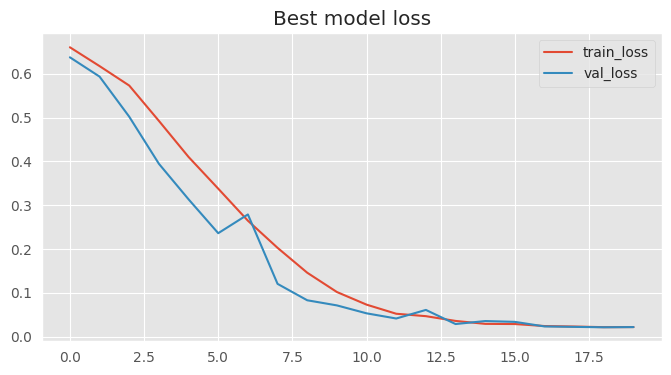

In [99]:
# Plot learning curves for best model
plt.figure(figsize=(8,4))
plt.plot(history_best.history['loss'], label='train_loss')
plt.plot(history_best.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Best model loss")
plt.savefig(os.path.join(OUTPUT_DIR, "best_model_loss.png"))

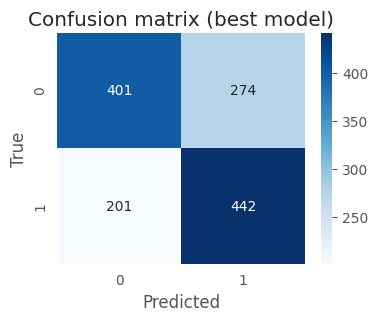

In [88]:
# Confusion matrix
cm = confusion_matrix(y_test, y_best)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion matrix (best model)")
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix_best.png"))

In [89]:
print(classification_report(y_test, y_best))

# ---------------------------
# 9) Explainability with SHAP
#    We'll use a surrogate approach for speed:
#    - Create a small dataset mapping inputs -> model predictions
#    - Train a LightGBM/RandomForest surrogate on tabular features (metadata + top-K tfidf features)
#    - Use SHAP TreeExplainer on surrogate (fast) for global/local interpretability
# Create tabular features: metadata + TF-IDF top features for text (faster)
N_TFIDF_FEATURES = 5000
tfidf2 = TfidfVectorizer(max_features=N_TFIDF_FEATURES, ngram_range=(1,2))
X_tfidf_all = tfidf2.fit_transform(df['description'].astype(str).tolist())
# Build tabular dataset aligned with train/test splits defined earlier
# Re-split the raw dataframe same method as used earlier for model splits
idx = np.arange(len(df))
idx_train, idx_temp, y_idx_train, y_idx_temp = train_test_split(idx, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)
idx_val, idx_test, _, _ = train_test_split(idx_temp, y_idx_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=y_idx_temp)

X_tab_train = np.hstack([meta_scaled[idx_train], X_tfidf_all[idx_train].toarray()])
X_tab_val = np.hstack([meta_scaled[idx_val], X_tfidf_all[idx_val].toarray()])
X_tab_test = np.hstack([meta_scaled[idx_test], X_tfidf_all[idx_test].toarray()])

y_tab_train = y[idx_train]
y_tab_val = y[idx_val]
y_tab_test = y[idx_test]

              precision    recall  f1-score   support

           0       0.67      0.59      0.63       675
           1       0.62      0.69      0.65       643

    accuracy                           0.64      1318
   macro avg       0.64      0.64      0.64      1318
weighted avg       0.64      0.64      0.64      1318



Total features for SHAP: 5023
Training Surrogate LightGBM for SHAP explanation...
[LightGBM] [Info] Number of positive: 3003, number of negative: 3145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34320
[LightGBM] [Info] Number of data points in the train set: 6148, number of used features: 1386
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488452 -> initscore=-0.046202
[LightGBM] [Info] Start training from score -0.046202
Calculating SHAP values...
Detected array format (New SHAP/Binary). Using directly.


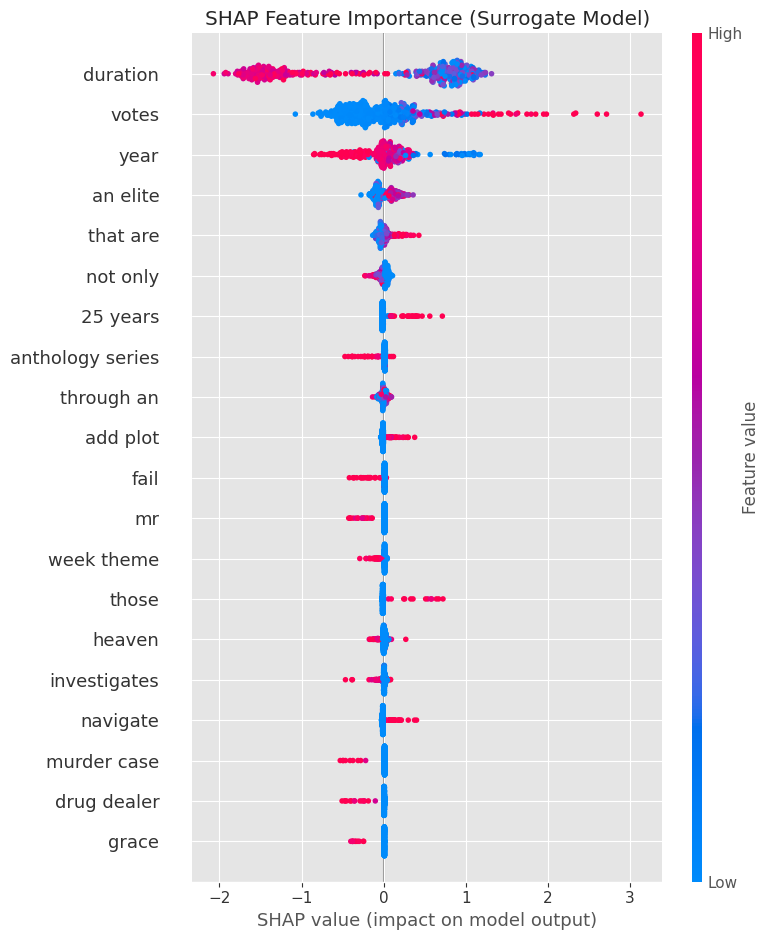

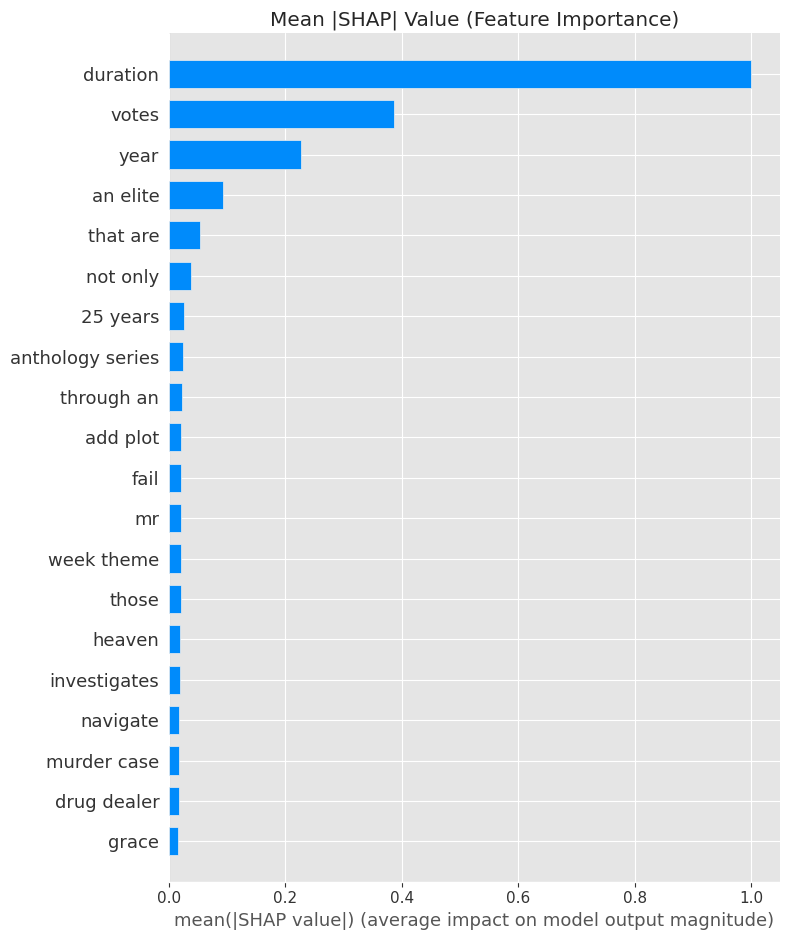

In [90]:
# 1. Construct Feature Names list (Metadata + Genre + TFIDF words)
# Ensure 'meta_cols', 'top_genres', and 'tfidf2' are defined from previous cells
feature_names_list = meta_cols + top_genres + list(tfidf2.get_feature_names_out())
print(f"Total features for SHAP: {len(feature_names_list)}")

# 2. Train Surrogate Model (LightGBM)
# We use the tabular data to approximate the LSTM's decision boundary for interpretation
print("Training Surrogate LightGBM for SHAP explanation...")
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=RANDOM_SEED)
lgb_model.fit(X_tab_train, y_tab_train)

# 3. Calculate SHAP Values
print("Calculating SHAP values...")
explainer = shap.TreeExplainer(lgb_model)
# Use a subset (first 500 test samples) for speed
shap_values = explainer.shap_values(X_tab_test[:500])

# --- CRITICAL FIX ---
# Check if shap_values is a list (old version/multiclass) or a single array (new version/binary)
if isinstance(shap_values, list):
    # If list, index 1 usually corresponds to the positive class
    print("Detected list format (Old SHAP/Multiclass). Selecting index 1.")
    shap_vals_to_plot = shap_values[1]
else:
    # If array, it is already the matrix for the positive class (or log odds)
    print("Detected array format (New SHAP/Binary). Using directly.")
    shap_vals_to_plot = shap_values

# 4. Plot Global Feature Importance (Summary Plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals_to_plot, X_tab_test[:500], feature_names=feature_names_list, show=False)
plt.title("SHAP Feature Importance (Surrogate Model)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "shap_summary_plot.png"))
plt.show()

# 5. Plot Bar Chart (Absolute Importance)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals_to_plot, X_tab_test[:500], feature_names=feature_names_list, plot_type="bar", show=False)
plt.title("Mean |SHAP| Value (Feature Importance)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "shap_bar_plot.png"))
plt.show()

In [100]:
results = {
    'baseline_lr_metrics': {
        'accuracy': accuracy_score(y_b_test, y_lr_pred),
        'f1': f1_score(y_b_test, y_lr_pred),
        'roc_auc': roc_auc_score(y_b_test, y_lr_pred_proba),
        'val_acc': val_acc  # assuming val_acc is defined
    },
    'baseline_lstm_metrics': {
        'accuracy': accuracy_score(
            y_test,
            (baseline_model.predict([X_text_test, X_meta_test])[:, 0] >= 0.5).astype(int)
        ),
        'f1': f1_score(
            y_test,
            (baseline_model.predict([X_text_test, X_meta_test])[:, 0] >= 0.5).astype(int)
        ),
        'roc_auc': roc_auc_score(
            y_test,
            baseline_model.predict([X_text_test, X_meta_test])[:, 0]
        )
    },
    'optuna_best_metrics': metrics_best,
    'optuna_best_params': best_params,
    'random_search_top5': random_trials[:5]
}

print("Key results:")
pprint(results)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Key results:
{'baseline_lr_metrics': {'accuracy': 0.6168437025796661,
                         'f1': 0.6045418950665623,
                         'roc_auc': np.float64(0.6627337134957664),
                         'val_acc': 0.6456752419471741},
 'baseline_lstm_metrics': {'accuracy': 0.6388467374810318,
                           'f1': 0.6699029126213593,
                           'roc_auc': np.float64(0.7010183745175971)},
 'optuna_best_metrics': {'accuracy': 0.990490198135376,
                         'learning_rate': 0.0009473202517256141,
                         'loss': 0.022173095494508743,
                         'max_val_auc': 0.999692440032959,
                         'val_accuracy': 0.9908952713012695,
                         'val_auc': 0.999692440032959,
                         'val_loss': 0.022090217098593712},
 'optuna_best_params': {'batch_size': 64,
 

In [103]:
MY_DESCRIPTION = "This movie is very bad. I don't like it."
MY_META_DATA = {
    'votes': 15000,
    'duration': 125,
    'year': 2018,
    'genre_primary': 'Drama'
}

sequences_test = tokenizer.texts_to_sequences([MY_DESCRIPTION])

X_text_predict = pad_sequences(
    sequences_test,
    maxlen=MAXLEN,
    padding='post',
    truncating='post'
)
print(f"✅ Text Input (X_text) Shape: {X_text_predict.shape}")

test_df = pd.DataFrame([MY_META_DATA])

meta_scaled_test = scaler.transform(test_df[meta_cols].fillna(0).values)

genre_matrix_test = np.array([genre_vector(g) for g in test_df['genre_primary']])

X_meta_predict = np.hstack([meta_scaled_test, genre_matrix_test])
print(f"✅ Meta Input (X_meta) Shape: {X_meta_predict.shape}")

probability = best_model.predict([X_text_predict, X_meta_predict])[0][0]

sentiment = "GOOD!" if probability >= 0.7 else "BAD!"

print("\n--- FINAL PREDICTION ---")
print(f"Description : {MY_DESCRIPTION}")
print(f"Probability: {probability:.4f}")
print(f"Final Result: {sentiment} ")

✅ Text Input (X_text) Shape: (1, 40)
✅ Meta Input (X_meta) Shape: (1, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

--- FINAL PREDICTION ---
Description : This movie is very bad. I don't like it.
Probability: 0.0024
Final Result: BAD! 
